In [1]:
import warnings
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset

label2id = {
    "Entertainment": 0,
    "Life": 1,
    "Politics": 2,
    "Sports": 3,
    "Voices": 4
}
         
id2label = {int(v):str(k) for k, v in label2id.items()}

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5, label2id=label2id, id2label=id2label)

2024-05-20 19:58:39.394437: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 19:58:39.439954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 19:58:40.159420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']


In [3]:
from src.main.models.transformers import Transformer
from src.main.pipeline.functions import clean_text, stop_words_removal
from src.main.utilities.utils import get_dataset, split_train_val_test

roberta = Transformer()

roberta.pipeline = [clean_text, stop_words_removal]

inputs, targets = get_dataset(one_hot=True)
inputs = roberta.run_pipeline(inputs, save=True)

x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)

train_data = {'text': x_train, 'label': y_train.values.astype(float)}
val_data = {'text': x_val, 'label': y_val.values.astype(float)}
test_data = {'text': x_test, 'label': y_test.values.astype(float)}

In [4]:
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

def tokenize_function(batch):
    return tokenizer(batch['text'], truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/75766 [00:00<?, ? examples/s]

Map:   0%|          | 0/21648 [00:00<?, ? examples/s]

Map:   0%|          | 0/10824 [00:00<?, ? examples/s]

In [5]:
from transformers import TrainingArguments, Trainer
import numpy as np
from datasets import load_metric

metrics = {
    "accuracy": load_metric("accuracy"),
    "precision": load_metric("precision"),
    "recall": load_metric("recall"),
    "f1": load_metric("f1"),
}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    references = np.argmax(labels, axis=1)
    accuracy = metrics["accuracy"].compute(predictions=predictions, references=references)
    precision = metrics["precision"].compute(predictions=predictions, references=references, average="macro")
    recall = metrics["recall"].compute(predictions=predictions, references=references, average="macro")
    f1 = metrics["f1"].compute(predictions=predictions, references=references, average="macro")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=8,              # total number of training epochs
    per_device_train_batch_size=16,   # batch size per device during training
    per_device_eval_batch_size=16,    # batch size for evaluation
    learning_rate=5e-5,              # learning rate
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.012,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,               # log every 500 steps
    evaluation_strategy="epoch",     # evaluate at the end of each epoch
    save_strategy="epoch",           # save the model at the end of each epoch
    load_best_model_at_end=True,     # load the best model when finished training (if using evaluation)
    metric_for_best_model="accuracy" # metric to use to compare models
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.168400,0.151442,0.864422,0.825215,0.803292,0.808223
2,0.141000,0.155166,0.874769,0.847677,0.801151,0.819878
3,0.112000,0.148034,0.880682,0.832716,0.829736,0.830104
4,0.098200,0.151733,0.882622,0.836090,0.834066,0.834990
5,0.084700,0.162352,0.883038,0.840366,0.831238,0.835660
6,0.070600,0.171805,0.884285,0.842359,0.830630,0.835401
7,0.051000,0.182421,0.885116,0.848723,0.829315,0.838268
8,0.046100,0.182520,0.883962,0.840032,0.833965,0.836930


TrainOutput(global_step=37888, training_loss=0.10126161615590791, metrics={'train_runtime': 2448.2497, 'train_samples_per_second': 247.576, 'train_steps_per_second': 15.476, 'total_flos': 1.33885765353105e+16, 'train_loss': 0.10126161615590791, 'epoch': 8.0})

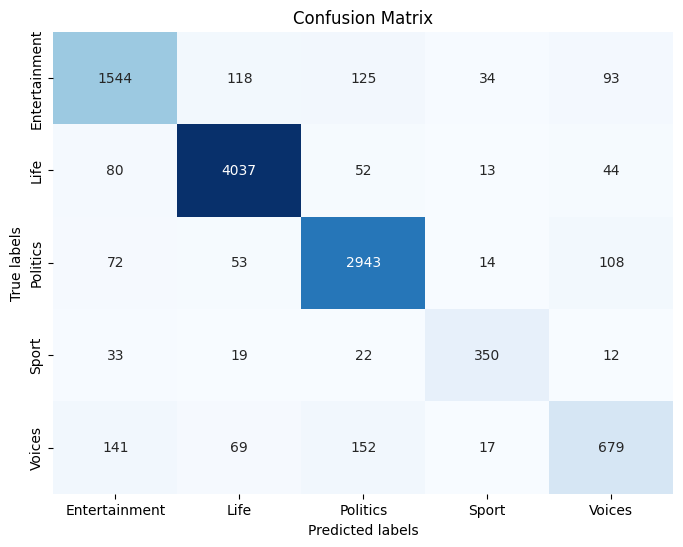

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1914
           1       0.94      0.96      0.95      4226
           2       0.89      0.92      0.91      3190
           3       0.82      0.80      0.81       436
           4       0.73      0.64      0.68      1058

    accuracy                           0.88     10824
   macro avg       0.84      0.83      0.83     10824
weighted avg       0.88      0.88      0.88     10824



In [6]:
from src.main.utilities import plotting
from sklearn.metrics import classification_report

result = trainer.predict(test_dataset)

predictions = np.argmax(result[0], axis=1)
target = np.argmax(result[1], axis=1)

plotting.plot_confusion_matrix(target, predictions)

print(classification_report(target, predictions))

In [7]:
trainer.save_model("./roberta_model")